In [1]:
import numpy as np
import pandas as pd
from pyomo.environ import *
import matplotlib.pyplot as plt

In [156]:
ELoad = pd.read_excel('data/electrical load/onDay.xlsx')
EPrice = pd.read_excel('data/electrical price/oneDay.xlsx')
PVLoad = pd.read_excel('data/PV/oneDay.xlsx')

In [157]:
ELoad['MV'].values

array([44514, 42804, 41199, 40274, 39691, 39866, 41833, 43941, 46584,
       49102, 50842, 52840, 53722, 53654, 52645, 52415, 54662, 57756,
       58146, 56229, 52532, 51354, 51075, 49192], dtype=int64)

In [158]:
ELoad = ELoad['MV'].values
EPrice = EPrice['price'].values
PVLoad = PVLoad['MV'].values

In [159]:
CCPV = 2000;
RCPV = 1700;
MCPV = 20;
CCel = 2000;
RCel = 1500;
MCel = 25;
etael = 0.75;
CCHST = 1300;
RCHST = 1200;
MCHST = 15;
etaHST = 0.95;
CCFC = 4000;
RCFC = 3500;
MCFC = 300;
etaFC = 0.5;
CCin = 800;
RCin = 750;
MCin = 15;
etain = 0.9;
HPrice = 1;

In [160]:
PVLoad = PVLoad/PVLoad.max()*600
EPrice = EPrice/1000
ELoad = ELoad/ELoad.max()*200

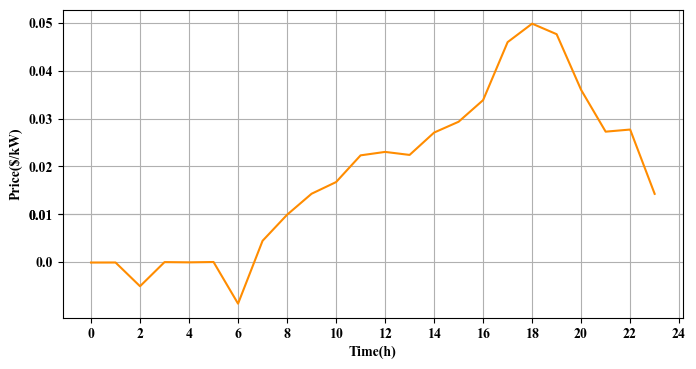

In [161]:
fig = plt.subplots(figsize =(8, 4))
plt.grid(True,zorder=-1)
plt.plot(list(range(24)),EPrice,color ='#FF8C00',alpha=1)
plt.xlabel('Time(h)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')
plt.ylabel('Price($/kW)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')

plt.yticks([0.01, 0.0, 0.01, 0.02 , 0.03, 0.04, 0.05], [ "0.01", "0.0", "0.01", "0.02" , "0.03", "0.04", "0.05"],
           fontname='Times New Roman', fontsize = 10, fontweight ='bold')

plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
           ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24'],
           fontname='Times New Roman',fontsize = 10, fontweight ='bold')
plt.gca().set_axisbelow(True)
plt.show()

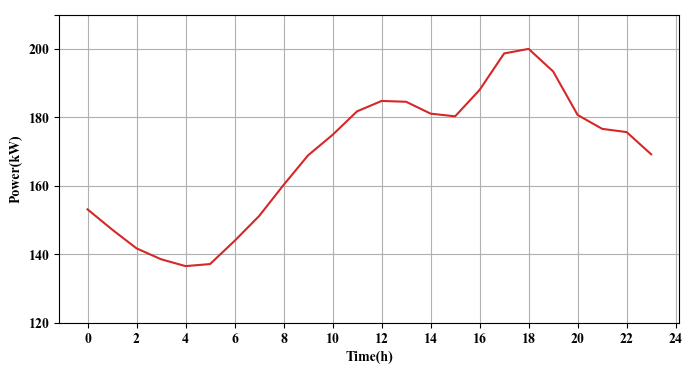

In [245]:
fig = plt.subplots(figsize =(8, 4))
plt.grid(True,zorder=-1)
plt.plot(list(range(24)),ELoad,color ='#d62728',alpha=1)
plt.xlabel('Time(h)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')
plt.ylabel('Power(kW)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')

plt.yticks([120, 140,160,180,200,210], [ "120", "140","160","180","200"," "],
           fontname='Times New Roman', fontsize = 10, fontweight ='bold')

plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
           ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24'],
           fontname='Times New Roman',fontsize = 10, fontweight ='bold')
plt.gca().set_axisbelow(True)
plt.show()

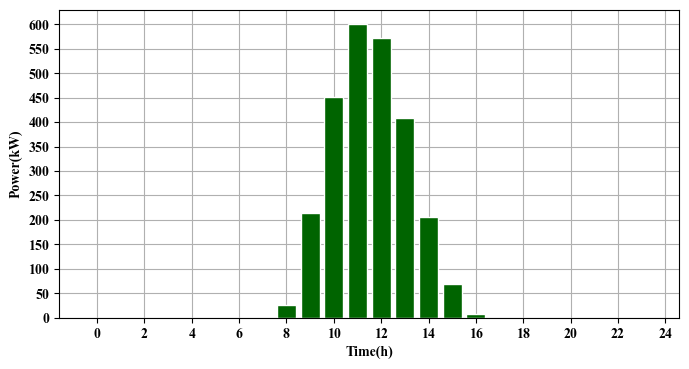

In [163]:
fig = plt.subplots(figsize =(8, 4))
plt.grid(True,zorder=-1)
plt.bar(list(range(24)),PVLoad,color ='#006400', edgecolor ='white',alpha=1)
plt.xlabel('Time(h)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')
plt.ylabel('Power(kW)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')

plt.yticks([0, 50, 100, 150, 200, 250, 300, 350 , 400, 450, 500, 550, 600],
           ["0", "50", "100", "150", "200", "250", "300", "350" , "400", "450", "500", "550", "600"],
           fontname='Times New Roman', fontsize = 10, fontweight ='bold')

plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
           ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24'], fontname='Times New Roman',fontsize = 10, 
           fontweight ='bold')
plt.gca().set_axisbelow(True)
plt.show()

In [218]:
model = ConcreteModel()

# varable define

In [219]:
model.x = Var([i for i in range(1,25)],within=Reals)
model.P_FC = Var([i for i in range(1,25)],within=NonNegativeReals)
model.P_EL = Var([i for i in range(1,25)],within=NonNegativeReals)
model.m = Var([i for i in range(1,25)],within=NonNegativeReals)

In [220]:
model.P_FC.setub(400)
model.P_EL.setub(400)

In [221]:
model.tset = Set(initialize = range(1,25))
e0 = 0

In [222]:
def con1(model,t):
    return model.x[t]*etain+PVLoad[t-1]+model.P_FC[t] == ELoad[t-1]/etain+model.P_EL[t]

In [223]:
def EHST(model,t):
    if t == 1:
        return e0+model.P_EL[t]*etael-model.P_FC[t]/etaFC*etaHST-39.7*model.m[t]*etaHST
    else:
        return EHST(model,t-1)+model.P_EL[t]*etael-model.P_FC[t]/etaFC*etaHST-39.7*model.m[t]*etaHST

In [224]:
def con2(model,t):
    return EHST(model,t)>=0

In [225]:
def con3(model,t):
    return EHST(model,t)<=75*39.7

In [226]:
model.obj = Objective(expr=sum(model.x[i]*EPrice[i-1] for i in range(1,25))-sum(model.m[i]*HPrice for i in range(1,25))
                      , sense=minimize)

In [227]:
model.con1 = Constraint(model.tset,rule=con1)

In [228]:
model.con2 = Constraint(model.tset,rule=con2)

In [229]:
model.con3 = Constraint(model.tset,rule=con3)

In [230]:
SolverFactory("glpk").solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': -38.1269393782577, 'Upper bound': -38.1269393782577, 'Number of objectives': 1, 'Number of constraints': 73, 'Number of variables': 97, 'Number of nonzeros': 1873, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.06995940208435059}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [231]:
print("Objective = ", model.obj())

Objective =  -38.12693937825765


In [232]:
a = [];
for i in range(1,25):
    a.append(model.x[i].value)
    print("x = ", model.x[i].value)
    

x =  633.470535854191
x =  626.209121101289
x =  619.393582692864
x =  615.465624420095
x =  612.989949097907
x =  613.733076338701
x =  622.085826525226
x =  631.037324945762
x =  613.992118265691
x =  414.63361721064
x =  159.36046996336
x =  -442.284704360628
x =  -406.344604158506
x =  -224.850872969088
x =  -5.73545379368438
x =  146.801802656078
x =  224.266603149507
x =  -199.186976334158
x =  -197.530864197531
x =  -205.671292315257
x =  223.074058362241
x =  218.071750421353
x =  216.886993277459
x =  653.335388610959


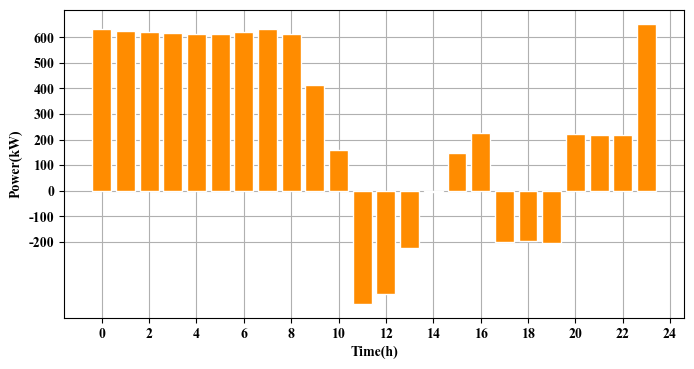

In [233]:
fig = plt.subplots(figsize =(8, 4))
plt.grid(True,zorder=-1)
plt.bar(list(range(24)),a,color ='#FF8C00', edgecolor ='white',alpha=1)
plt.xlabel('Time(h)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')
plt.ylabel('Power(kW)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')

plt.yticks([-200, -100, 0, 100, 200, 300, 400, 500 , 600],
           ['-200', "-100", '0', '100', '200', '300', '400', '500' , '600'],
           fontname='Times New Roman', fontsize = 10, fontweight ='bold')

plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
           ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24'], fontname='Times New Roman',fontsize = 10, 
           fontweight ='bold')
plt.gca().set_axisbelow(True)
plt.show()

In [234]:
def EHSTCal(model,t):
    if t == 1:
        return e0+model.P_EL[t].value*etael-model.P_FC[t].value/etaFC*etaHST-39.7*model.m[t].value*etaHST
    else:
        return EHSTCal(model,t-1)+model.P_EL[t].value*etael-model.P_FC[t].value/etaFC*etaHST-39.7*model.m[t].value*etaHST

In [235]:
EHSTCal(model,2)

577.5000000000003

In [236]:
a = []
for i in range(1,25):
    a.append(EHSTCal(model,i))
    print("EHSTCal = ", EHSTCal(model,i))

EHSTCal =  277.50000000000034
EHSTCal =  577.5000000000003
EHSTCal =  877.5000000000003
EHSTCal =  1177.5000000000005
EHSTCal =  1477.5000000000005
EHSTCal =  1777.5000000000005
EHSTCal =  2077.5000000000005
EHSTCal =  2377.5000000000005
EHSTCal =  2677.5000000000005
EHSTCal =  2977.5000000000005
EHSTCal =  2977.5000000000005
EHSTCal =  2977.5000000000005
EHSTCal =  2977.5000000000005
EHSTCal =  2977.5000000000005
EHSTCal =  2977.5000000000005
EHSTCal =  2977.5000000000005
EHSTCal =  2977.5000000000005
EHSTCal =  2217.5000000000005
EHSTCal =  1457.5000000000005
EHSTCal =  697.5000000000005
EHSTCal =  1.1368683772161603e-13
EHSTCal =  1.1368683772161603e-13
EHSTCal =  1.1368683772161603e-13
EHSTCal =  0.0


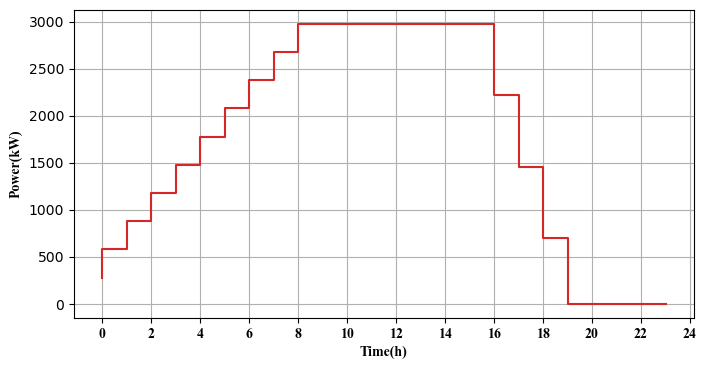

In [237]:
fig = plt.subplots(figsize =(8, 4))
plt.grid(True,zorder=-1)
plt.step(list(range(24)),a,color ='#d62728',alpha=1)
plt.xlabel('Time(h)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')
plt.ylabel('Power(kW)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')

#plt.yticks([0, 100, 200, 300, 400, 500, 600, 700 , 800],
#           ['0', "100", '200', '300', '400', '500', '600', '700' , '800'],
#           fontname='Times New Roman', fontsize = 10, fontweight ='bold')

plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
           ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24'], fontname='Times New Roman',fontsize = 10, 
           fontweight ='bold')
plt.gca().set_axisbelow(True)
plt.show()

In [238]:
a = []
for i in range(1,25):
    a.append(model.P_EL[i].value)
    print("x = ", model.P_EL[i].value)

x =  400.0
x =  400.0
x =  400.0
x =  400.0
x =  400.0
x =  400.0
x =  400.0
x =  400.0
x =  400.0
x =  400.0
x =  400.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  400.0


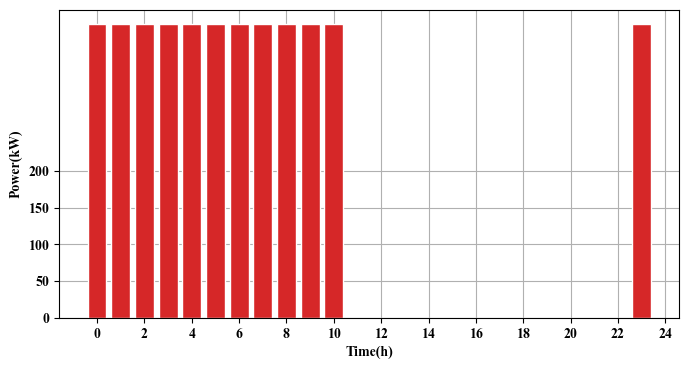

In [239]:
fig = plt.subplots(figsize =(8, 4))
plt.grid(True,zorder=-1)
plt.bar(list(range(24)),a,color ='#d62728', edgecolor ='white',alpha=1)
plt.xlabel('Time(h)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')
plt.ylabel('Power(kW)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')

plt.yticks([0, 50, 100, 150, 200,],
           ['0', '50', "100", '150', '200'],
           fontname='Times New Roman', fontsize = 10, fontweight ='bold')

plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
           ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24'], fontname='Times New Roman',fontsize = 10, 
           fontweight ='bold')
plt.gca().set_axisbelow(True)
plt.show()

In [240]:
b = [];
for i in range(1,25):
    b.append(model.P_FC[i].value)
    print("x = ", model.P_FC[i].value)

x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  400.0
x =  400.0
x =  400.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0


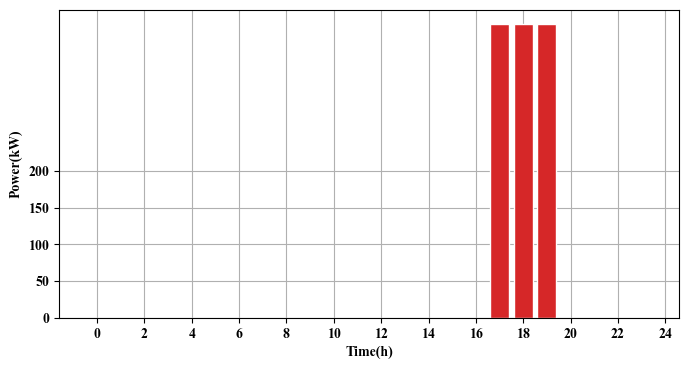

In [241]:
fig = plt.subplots(figsize =(8, 4))
plt.grid(True,zorder=-1)
plt.bar(list(range(24)), b, color ='#d62728', edgecolor ='white',alpha=1)
plt.xlabel('Time(h)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')
plt.ylabel('Power(kW)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')

plt.yticks([0, 50, 100, 150, 200,],
           ['0', '50', "100", '150', '200'],
           fontname='Times New Roman', fontsize = 10, fontweight ='bold')

plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
           ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24'], fontname='Times New Roman',fontsize = 10, 
           fontweight ='bold')
plt.gca().set_axisbelow(True)
plt.show()

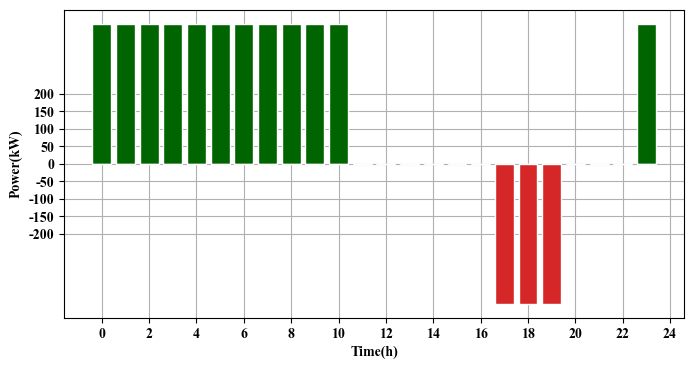

In [242]:
fig = plt.subplots(figsize =(8, 4))
plt.grid(True,zorder=-1)
plt.bar(list(range(24)), a, color ='#006400', edgecolor ='white',alpha=1)
plt.bar(list(range(24)), [-i for i in b], color ='#d62728', edgecolor ='white',alpha=1)
plt.xlabel('Time(h)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')
plt.ylabel('Power(kW)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')

plt.yticks([-200, -150, -100, -50, 0, 50, 100, 150, 200],
           ['-200', '-150', '-100', '-50', '0', '50', "100", '150', '200'],
           fontname='Times New Roman', fontsize = 10, fontweight ='bold')

plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
           ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24'], fontname='Times New Roman',fontsize = 10, 
           fontweight ='bold')
plt.gca().set_axisbelow(True)
plt.show()

In [243]:
b = [];
for i in range(1,25):
    b.append(model.m[i].value)
    print("x = ", model.m[i].value)

x =  0.596579610234645
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  7.95439480312873
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  0.0
x =  18.4939679172743
x =  0.0
x =  0.0
x =  7.95439480312873


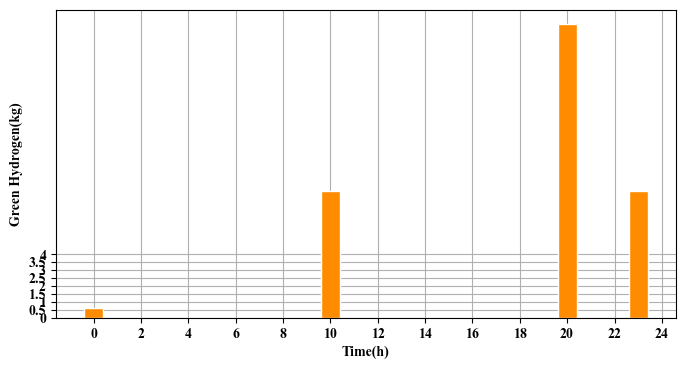

In [244]:
fig = plt.subplots(figsize =(8, 4))
plt.grid(True,zorder=-1)
plt.bar(list(range(24)), b, color ='#FF8C00', edgecolor ='white',alpha=1)
plt.xlabel('Time(h)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')
plt.ylabel('Green Hydrogen(kg)',fontweight ='bold', fontsize = 10,fontname='Times New Roman')

plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
           ['0', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4'],
           fontname='Times New Roman', fontsize = 10, fontweight ='bold')

plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
           ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24'], fontname='Times New Roman',fontsize = 10, 
           fontweight ='bold')
plt.gca().set_axisbelow(True)
plt.show()